# Задание на программирование

**Выполнять задание следует с текущими значениями гиперпараметров. Для проверки ниже будут приведены ответы, которые должны получиться в результате выполнения задания. После того, как все ответы совпадут, можно будет использовать полученный блокнот для выполнения индивидуального задания.**

Зададим гиперпараметры модели

In [85]:
epsilon = 0.1 # Параметр эпсилон при использовании эпсилон жадной стратегии
gamma = 0.9 # Коэффциент дисконтирования гамма
random_seed = 2 #Random seed
time_delay = 1 # Задержка времени при отрисовке процесса игры после обучения (секунды)
lr_rate = 0.9 #Коэффициент скорости обучения альфа

Импортируем библиотеки, создаем свою среду размера 6х6. S обозначает точку старта. F -- лед безопасен, H -- проталина, G -- цель. Параметр `is_slippery=False` отвечает за условное отсутствие скольжения. То есть если агент выбрал действие пойти направо, то он переместится в соответствующее состояние. В общем случае из-за "скольжения" можно оказаться в другом состоянии. Мы также скопировали из библиотки GYM и слегка модифицировали функцию ```generate_random_map ```, для того, чтобы генерировать произвольные карты на основе ```random_seed ```.





In [86]:
# Установим нужную версию библиотеки gym
!git clone https://github.com/dvolchek/gym_0_18_0.git -q
%cd gym_0_18_0
!pip install -e. -q
%pip install scipy
%pip install matplotlib

fatal: could not create work tree dir 'gym_0_18_0': No such file or directory
[Errno 2] No such file or directory: 'gym_0_18_0'
/Users/kirill/PycharmProjects/advanced-ml-python-deep-learning/exercise9/gym_0_18_0/gym_0_18_0/gym_0_18_0
The folder you are executing pip from can no longer be found.
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.9/3.9.18/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/homebrew/Cellar/python@3.9/3.9.18/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/homebrew/lib/python3.9/site-packages/pip/__main__.py", line 8, in <module>
    if sys.path[0] in ("", os.getcwd()):
FileNotFoundError: [Errno 2] No such file or directory
Note: you may need to restart the kernel to use updated packages.
Traceback (most recent call last):
  File "/opt/homebrew/Cellar

In [87]:
import gym
import numpy as np
import time
from IPython.display import clear_output


def generate_random_map(size, p, sd):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False
    np.random.seed(sd)

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0,0))
        while frontier:
            r, c = frontier.pop()
            if not (r,c) in discovered:
                discovered.add((r,c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == 'G':
                        return True
                    if (res[r_new][c_new] not in '#H'):
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]

#Генерация карты
random_map = generate_random_map(size=6, p=0.8, sd = random_seed) #Создаем свою карту
env = gym.make("FrozenLake-v0", desc=random_map, is_slippery=False) #Инициализируем среду
print("Ваша карта")
env.render() #Выводим карту на экран

Ваша карта

SFFFFF
FFFFFF
FFFFHF
HFFFFF
FFFFFF
FFFFFG


Функции выбора действия и обновления таблицы ценности действий. Строчка *** используется для того, чтобы проверять ответы в openedx. Вне рамках академической задачи лучше использовать оригинальный метод класса `environment`, то есть:

`action = env.action_space.sample()`

# Задача 1
Дополните функцию ```learn()```, чтобы в результате ее вызова обновлялось значение ценности текущего действия согласно алгоритму Q-обучения



In [88]:
def choose_action(state):
    action=0
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0,env.action_space.n) #***
    else:
        action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

def learn(state, state2, reward, action, done):
    # Вычисляем максимальное значение Q для нового состояния state2
    # max_q = np.max(Q[state2, :])
    
    # Обновляем значение Q-функции для текущей пары состояние-действие
    # Q[state, action] = (1 - lr_rate) * Q[state, action] + lr_rate * (reward + gamma * max_q)
    Q[state, action] = Q[state, action] + lr_rate * (reward + gamma * np.max(Q[state2,:]) - Q[state, action])


# Задача 2
Дополните следующий код так, чтобы в результате обучения модели можно было узнать количество побед и номер игры (`game`), на котором агент впервые одержал пятую победу подряд.

Поясним, что возвращает функция ```env.step(action)```

```state2``` -- следующее состояние

```reward``` -- награда

```done``` -- флаг окончания игры. True в случае победы или падения в проталину. False в остальных случаях.




In [89]:
from tqdm import tqdm

# Inititalization
np.random.seed(random_seed)
total_games = 10000
max_steps = 100
Q = np.zeros((env.observation_space.n, env.action_space.n))
wins_in_a_row = 0
total_wins = 0
game_of_fifth_win = None

# Main cycle
for game in tqdm(range(total_games)):
    state = env.reset()
    t = 0
    while t < max_steps:
        t += 1
        action = choose_action(state)
        state2, reward, done, info = env.step(action)
        if t == max_steps:
            done = True
        learn(state, state2, reward, action, done)
        state = state2
        if done:
            if reward > 0:  # if it's a win
                total_wins += 1
                wins_in_a_row += 1
                if wins_in_a_row == 5 and game_of_fifth_win is None:
                    game_of_fifth_win = game + 1
            else:
                wins_in_a_row = 0  # reset the wins in a row counter if the agent didn't win
            break

100%|██████████| 10000/10000 [00:02<00:00, 4828.62it/s]


Вывод ответов при заданных параметрах

In [90]:
print("Количество побед в серии из 10 000 игр: ", total_wins)
print("Пять побед подряд впервые было одержано в игре ", game_of_fifth_win)


Количество побед в серии из 10 000 игр:  9561
Пять побед подряд впервые было одержано в игре  81


Должны получиться следующие результаты.


*  Количество побед в серии из 10 000 игр:  7914
*  Пять побед подряд впервые было одержано в игре  885




Произведем одну игру, чтобы проследить за действиями агента. При этом будем считать модель полностью обученной, то есть действия выбираются жадно, значения ценностей действий в таблице не обновляются.

In [91]:
import time
#Жадный выбор действий
def choose_action_one_game(state):
    action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

states=[]#Массив для сохранения состояний агента в течение игры
t = 0
state = env.reset()
wn = 0
while(t<100):
    env.render()
    time.sleep(time_delay)
    clear_output(wait=True)
    action = choose_action_one_game(state)
    state2, reward, done, info = env.step(action)
    states.append(state)
    state = state2
    t += 1
    if done and reward == 1:
        wn=1
    if done:
        break
if wn == 1:
    print("Победа!")

Победа!


Отобразим маршрут

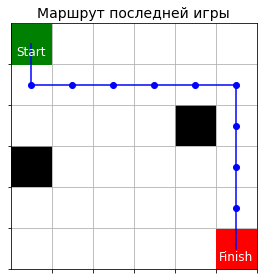

In [92]:
import matplotlib.pyplot as plt

def make_maze_pic(maze):
    maze_pic=[]
    for i in range(len(maze)):
        row = []
        for j in range(len(maze[i])):
            if maze[i][j] == 'S':
                row.append(0)
            if maze[i][j] == 'F':
                row.append(0)
            if maze[i][j] == 'H':
                row.append(1)
            if maze[i][j] == 'G':
                row.append(0)
        maze_pic.append(row)
    maze_pic = np.array(maze_pic)
    return maze_pic


#Make maze fit to plot
maze_pic = make_maze_pic(random_map)
nrows, ncols = maze_pic.shape

rw = np.remainder(states, nrows)
cl = np.floor_divide(states, nrows)

if wn == 1:
    rw = np.append(rw, [nrows-1])
    cl = np.append(cl, [ncols-1])

path = list(zip(rw, cl))

fig, ax1 = plt.subplots(1, 1, tight_layout=True)
ax1.clear()
ax1.set_xticks(np.arange(0.5, nrows, step=1))
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0.5, ncols, step=1))
ax1.set_yticklabels([])
ax1.grid(True)
ax1.plot([0], [0], "gs", markersize=40)
ax1.text(0, 0.2, "Start", ha="center", va="center", color="white", fontsize=12)
ax1.plot([nrows-1], [ncols-1], "rs", markersize=40)
ax1.text(nrows-1, ncols-1+0.2, "Finish", ha="center", va="center", color="white", fontsize=12)
ax1.plot(rw, cl, "bo")
ax1.plot(path[0][0], path[0][1], "go", markersize=20)
ax1.plot(path[-1][0], path[-1][1], "ro", markersize=20)
for i in range(len(path)-1):
    ax1.plot([path[i][0], path[i+1][0]], [path[i][1], path[i+1][1]], ls='-', color='blue')
ax1.set_title('Маршрут последней игры', fontsize=14)
ax1.imshow(maze_pic, cmap="binary")